# ADA CAPI Notebook for Data Exploration

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import os
import urllib
import datetime as datetime
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# load config and extract variables
import config
DATA_PATH = config.PATH_TO_DATA

### Loading and Preparing the Data
Load and clean up the paths, load into weighted graph structure etc.

#### Load Data

In [2]:
# load in all data (except wikipedia articles)
finished_paths = pd.read_csv(os.path.join(DATA_PATH, "paths_finished.tsv"), sep='\t', skiprows=15, names=["hashedIpAddress", "timestamp", "durationInSec", "path", "rating"])
unfinished_paths = pd.read_csv(os.path.join(DATA_PATH, "paths_unfinished.tsv"), sep='\t', skiprows=16, names=["hashedIpAddress", "timestamp", "durationInSec", "path", "target", "type"])
edges = pd.read_csv(os.path.join(DATA_PATH, "links.tsv"), sep='\t', skiprows=15, names=["start", "end"], encoding="utf-8")
articles = pd.read_csv(os.path.join(DATA_PATH, "articles.tsv"), sep='\t', skiprows=12, names=["article"], encoding="utf-8")
categories = pd.read_csv(os.path.join(DATA_PATH, "categories.tsv"), sep='\t', skiprows=13, names=["article", "category"], encoding="utf-8")
shortest_paths = np.genfromtxt(os.path.join(DATA_PATH, "shortest-path-distance-matrix.txt"), delimiter=1, dtype=np.uint8)

In [3]:
finished_paths.info()
display(finished_paths.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51318 entries, 0 to 51317
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   hashedIpAddress  51315 non-null  object 
 1   timestamp        51318 non-null  int64  
 2   durationInSec    51318 non-null  int64  
 3   path             51318 non-null  object 
 4   rating           28501 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 2.0+ MB


,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0


In [4]:
unfinished_paths.info()
display(unfinished_paths.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24875 entries, 0 to 24874
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   hashedIpAddress  24875 non-null  object
 1   timestamp        24875 non-null  int64 
 2   durationInSec    24875 non-null  int64 
 3   path             24875 non-null  object
 4   target           24875 non-null  object
 5   type             24875 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.1+ MB


,hashedIpAddress,timestamp,durationInSec,path,target,type
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout


In [5]:
edges.info()
edges.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119879 entries, 0 to 119878
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   start   119879 non-null  object
 1   end     119879 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB


,start,end
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Isle_of_Man
3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Monarchy
4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Orkney


In [6]:
articles.info()
articles.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4604 entries, 0 to 4603
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   article  4604 non-null   object
dtypes: object(1)
memory usage: 36.1+ KB


,article
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in
1,%C3%85land
2,%C3%89douard_Manet
3,%C3%89ire
4,%C3%93engus_I_of_the_Picts


In [7]:
categories.head()
categories.head()

,article,category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_Histor...
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.People.Historical_figures
2,%C3%85land,subject.Countries
3,%C3%85land,subject.Geography.European_Geography.European_...
4,%C3%89douard_Manet,subject.People.Artists


In [8]:
# shortest paths corresponds to numpy matrix, where 255 signifies no path (underscore in the .txt file), the diagonal is zero
# the row index is the zero-based index corresponding to the index in the articles dataframe, same for the columns (target article)
print((np.diag(shortest_paths)==0).all())
shortest_paths

True


array([[  0, 255, 255, ...,   4,   4,   2],
       [255,   0, 255, ...,   3,   3,   3],
       [255, 255,   0, ...,   3,   3,   3],
       ...,
       [255, 255, 255, ...,   0,   3,   3],
       [255, 255, 255, ...,   4,   0,   3],
       [255, 255, 255, ...,   3,   3,   0]], dtype=uint8)

#### Clean up

In [9]:
# Clean up edge list
display(edges.head())
edges["start"] = edges.start.apply(urllib.parse.unquote)
edges["end"] = edges.end.apply(urllib.parse.unquote)
display(edges.head())

,start,end
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Isle_of_Man
3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Monarchy
4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Orkney


,start,end
0,Áedán_mac_Gabráin,Great_Britain
1,Áedán_mac_Gabráin,Ireland
2,Áedán_mac_Gabráin,Isle_of_Man
3,Áedán_mac_Gabráin,Monarchy
4,Áedán_mac_Gabráin,Orkney


In [10]:
# format datetime as datetime object
finished_paths["datetime"] = finished_paths.timestamp.apply(datetime.datetime.fromtimestamp)
unfinished_paths["datetime"] = unfinished_paths.timestamp.apply(datetime.datetime.fromtimestamp)
display(unfinished_paths.head())

,hashedIpAddress,timestamp,durationInSec,path,target,type,datetime
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout,2011-02-07 06:02:15
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout,2011-02-07 06:14:11
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout,2011-02-07 16:00:19
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart,2011-02-07 17:06:01
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout,2011-02-07 18:18:25


In [11]:
# clean up url encoding for articles
display(articles.head())
articles["article"] = articles.article.apply(urllib.parse.unquote)
display(articles.head())

,article
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in
1,%C3%85land
2,%C3%89douard_Manet
3,%C3%89ire
4,%C3%93engus_I_of_the_Picts


,article
0,Áedán_mac_Gabráin
1,Åland
2,Édouard_Manet
3,Éire
4,Óengus_I_of_the_Picts


In [12]:
# clean up url encoding for categories
display(categories.head())
categories["article"] = categories.article.apply(urllib.parse.unquote)
display(categories.head())

,article,category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_Histor...
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.People.Historical_figures
2,%C3%85land,subject.Countries
3,%C3%85land,subject.Geography.European_Geography.European_...
4,%C3%89douard_Manet,subject.People.Artists


,article,category
0,Áedán_mac_Gabráin,subject.History.British_History.British_Histor...
1,Áedán_mac_Gabráin,subject.People.Historical_figures
2,Åland,subject.Countries
3,Åland,subject.Geography.European_Geography.European_...
4,Édouard_Manet,subject.People.Artists


In [13]:
# merge articles and categories
articles_categories = pd.merge(articles, categories, how="left", on="article")
display(articles_categories.head())
# 6 articles without category!
print("Merge introduced {} NAs in category columns:".format(articles_categories.category.isna().sum()))
articles_categories[articles_categories.category.isna()]

,article,category
0,Áedán_mac_Gabráin,subject.History.British_History.British_Histor...
1,Áedán_mac_Gabráin,subject.People.Historical_figures
2,Åland,subject.Countries
3,Åland,subject.Geography.European_Geography.European_...
4,Édouard_Manet,subject.People.Artists


Merge introduced 6 NAs in category columns:


,article,category
1360,Directdebit,NaN
1385,Donation,NaN
1811,Friend_Directdebit,NaN
3670,Pikachu,NaN
4342,Sponsorship_Directdebit,NaN
5141,Wowpurchase,NaN


In [14]:
# Convert paths to a readable format (lists)

finished_paths_readable = finished_paths.copy()
finished_paths_readable["readable_path"] = finished_paths_readable["path"].apply(lambda x: x.split(";"))
finished_paths_readable["readable_path"] = finished_paths_readable["readable_path"].apply(lambda x: [urllib.parse.unquote(y) for y in x])

unfinished_paths_readable = unfinished_paths.copy()
unfinished_paths_readable["readable_path"] = unfinished_paths_readable["path"].apply(lambda x: x.split(";"))
unfinished_paths_readable["readable_path"] = unfinished_paths_readable["readable_path"].apply(lambda x: [urllib.parse.unquote(y) for y in x])
unfinished_paths_readable["target"] = unfinished_paths_readable["target"].apply(urllib.parse.unquote)

In [15]:
# functions to get all links between articles
from itertools import tee
def pairwise(iterable):
    # from python docs - will be introduced in version 3.10
    # pairwise('ABCDEFG') --> AB BC CD DE EF FG
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)


def get_all_links(df, path_colname="path"):
    edge_counter = {}
    for _, row in df.iterrows():
        links = row['path'].split(';')
        
        edges = list(pairwise(links))

        for edge in edges:
            if edge in edge_counter:
                edge_counter[edge] += 1
            else:
                edge_counter[edge] = 1

    out = pd.Series(edge_counter).reset_index()
    out.columns = ["source", "target", "weight"]
    return out



In [16]:
# get all finished links
finished_links = get_all_links(finished_paths)
finished_links.sort_values(by="weight", ascending=False) # TODO: what is up with these <<< signs?


,source,target,weight
66,<,<,4971
8550,Communication,Telephone,533
25,North_America,United_States,492
579,Animal,Mammal,487
2127,Lion,Zebra,472
...,...,...,...
34539,Latin_America,Guyana,1
34538,Wine,Latin_America,1
34532,Crow,Dove,1
34530,Symmetry,Physics,1


In [17]:
# get all unfinished links
unfinished_links = get_all_links(unfinished_paths)
unfinished_links.sort_values(by="weight", ascending=False) # TODO: what is up with these <<< signs?


,source,target,weight
63,<,<,3814
5155,Pyramid,Mexico,278
5209,Brain,Computer_science,222
392,Animal,Mammal,187
159,<,United_States,171
...,...,...,...
18326,Electromagnetic_radiation,Gauss%27s_law,1
18324,History_of_computing_hardware,History_of_the_Internet,1
18323,Scurvy,Pellagra,1
18322,River,Germany,1


count    2788.000000
mean        1.495696
std        13.778984
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       240.000000
dtype: float64

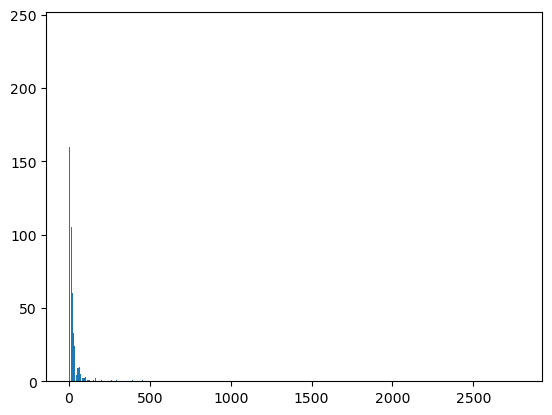

In [18]:
# create newtorkx graph from finished paths
finished_graph = nx.from_pandas_edgelist(finished_links,source="source", target="target", edge_attr="weight")
hist = nx.degree_histogram(finished_graph)
plt.bar(range(len(hist)), hist)
pd.Series(hist).describe()

count    2284.000000
mean        1.761821
std        18.526944
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       363.000000
dtype: float64

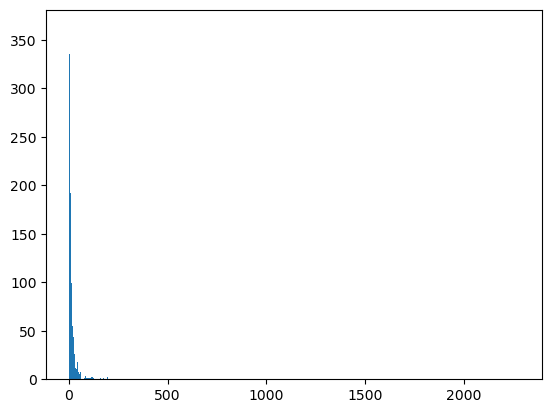

In [19]:
# create newtorkx graph from unfinished paths
unfinished_graph = nx.from_pandas_edgelist(unfinished_links,source="source", target="target", edge_attr="weight")
hist = nx.degree_histogram(unfinished_graph)
plt.bar(range(len(hist)), hist)
pd.Series(hist).describe()

### General Data Exploration
Explore distribution of all relevant variables, analyze and potentially fill missing values, sîmple summary stats

#### Explore Path lengths across finished and unfinished paths

In [20]:
# distribution of path lengths disaggregated across finished and unfinished
unfinished_paths["path_length"] = unfinished_paths.path.apply(lambda el: len(el.split(";")))
finished_paths["path_length"] = finished_paths.path.apply(lambda el: len(el.split(";")))

print("Finished Paths: Length")
display(finished_paths["path_length"].describe())
display(finished_paths.path_length.value_counts())

print("Unfinished Paths: Length")
display(unfinished_paths["path_length"].describe())
unfinished_paths.path_length.value_counts()


Finished Paths: Length


count    51318.000000
mean         6.757434
std          4.680718
min          1.000000
25%          5.000000
50%          6.000000
75%          8.000000
max        435.000000
Name: path_length, dtype: float64

path_length
5     10941
4      8558
6      8137
7      5868
8      3954
      ...  
72        1
86        1
71        1
66        1
69        1
Name: count, Length: 79, dtype: int64

Unfinished Paths: Length


count    24875.000000
mean         5.197789
std          5.772234
min          1.000000
25%          2.000000
50%          4.000000
75%          7.000000
max        235.000000
Name: path_length, dtype: float64

path_length
1      5214
2      3223
3      3165
4      2727
5      2457
       ... 
92        1
67        1
58        1
235       1
86        1
Name: count, Length: 75, dtype: int64

Text(0.5, 1.0, 'Uninished Paths')

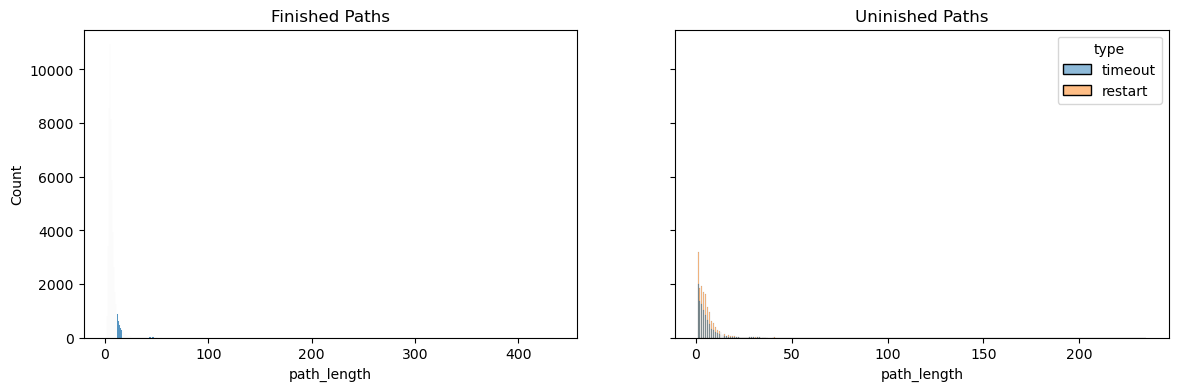

In [21]:
# make plot of path lengths
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4), sharey=True)

sns.histplot(data=finished_paths, x="path_length", ax=axes[0])
axes[0].set_title("Finished Paths")
sns.histplot(data=unfinished_paths, x="path_length", ax=axes[1], hue="type")
axes[1].set_title("Uninished Paths")

# --> highly skewed and many unlikely outcomes (e.g. unfinished paths path length = 1, did they really give up? or not play at all?)

Text(0.5, 1.0, 'Uninished Paths - Timeout')

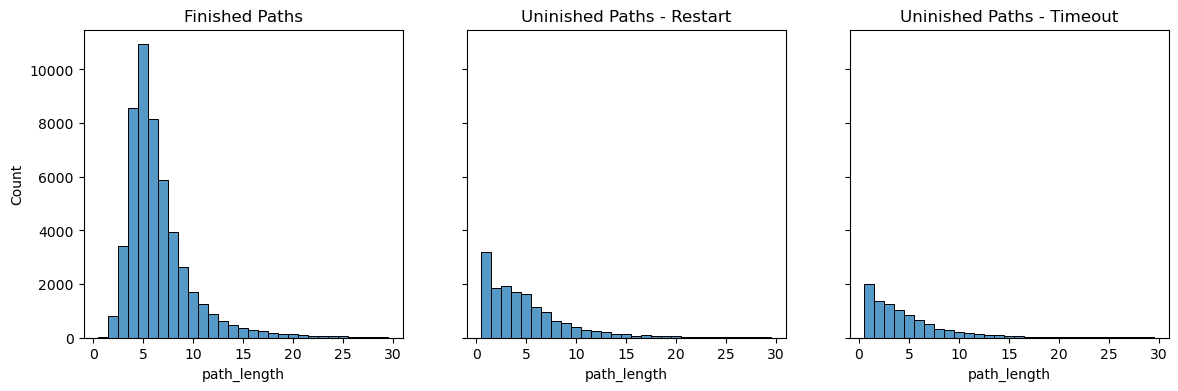

In [22]:
# TODO: plot comparing path lengths after cleaning up (e.g., kicking out top 10 percentiles, log transforms etc.) to better understand what is going on

# make plot of path lengths
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 4), sharey=True)
threshold = 30


sns.histplot(x=finished_paths.path_length[finished_paths.path_length < threshold], ax=axes[0], discrete=True)
axes[0].set_title("Finished Paths")

unfinished_clean = unfinished_paths[(unfinished_paths.path_length < threshold) & (unfinished_paths.type == "restart")]
sns.histplot(data=unfinished_clean, x="path_length", ax=axes[1], discrete=True,)
axes[1].set_title("Uninished Paths - Restart")

unfinished_clean = unfinished_paths[(unfinished_paths.path_length < threshold) & (unfinished_paths.type == "timeout")]
sns.histplot(data=unfinished_clean, x="path_length", ax=axes[2], discrete=True,)
axes[2].set_title("Uninished Paths - Timeout")

#### Explore categories in the paths

In [23]:
# Seeing which categories are most represented in articles

broad_categories = categories.copy()
broad_categories["broad_category"] = broad_categories["category"].apply(lambda x: x.split(".")[1])

count_articles = broad_categories.groupby("broad_category").size()

print("Below shows how many articles each of the broad categories are represented by")
display(count_articles)

Below shows how many articles each of the broad categories are represented by


broad_category
Art                          38
Business_Studies             88
Citizenship                 224
Countries                   229
Design_and_Technology       254
Everyday_life               374
Geography                  1084
History                     545
IT                           85
Language_and_literature     196
Mathematics                  45
Music                        97
People                      689
Religion                    134
Science                    1122
dtype: int64

In [24]:
# Create dictionaries for easy discovery of what categories an article belongs to
article_to_category = {}
article_to_broad_category = {}
for i in range(len(broad_categories)):
    if broad_categories.iloc[i]["article"] in article_to_category:
        article_to_category[broad_categories.iloc[i]["article"]].append(broad_categories.iloc[i]["category"])
        article_to_broad_category[broad_categories.iloc[i]["article"]].append(broad_categories.iloc[i]["broad_category"])
    else:
        article_to_category[broad_categories.iloc[i]["article"]] = [broad_categories.iloc[i]["category"]]
        article_to_broad_category[broad_categories.iloc[i]["article"]] = [broad_categories.iloc[i]["broad_category"]]

Counter({'Science': 14294,
         'Geography': 13301,
         'History': 6402,
         'People': 6074,
         'Everyday_life': 5046,
         'Countries': 4155,
         'Design_and_Technology': 2995,
         'Citizenship': 2189,
         'Religion': 1828,
         'IT': 1348,
         'Language_and_literature': 1345,
         'Music': 941,
         'Business_Studies': 889,
         'Mathematics': 540,
         'Art': 334})

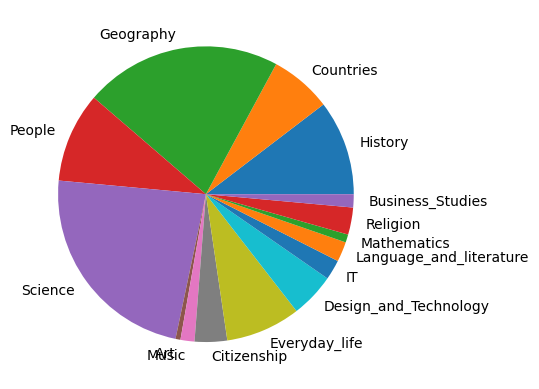

In [25]:
# Count how many times each category has occured as a target in the finished paths

# NOTE THAT SOME ARTICLES ARE REPRESENTED BY MULTIPLE CATEGORIES AND ARE COUNTED TWICE
all_target_broad_categories_f = [article_to_broad_category[target] for target in [path[-1] for path in finished_paths_readable["readable_path"]] if target in article_to_broad_category]
all_target_broad_categories_f = [item for sublist in all_target_broad_categories_f for item in sublist]
count_cats_finished_target = Counter(all_target_broad_categories_f)
display(count_cats_finished_target)

ax = plt.pie(count_cats_finished_target.values(), labels = count_cats_finished_target.keys())
plt.show()

Counter({'Science': 7862,
         'Everyday_life': 4118,
         'Geography': 3443,
         'History': 3315,
         'People': 2755,
         'Design_and_Technology': 2188,
         'Citizenship': 1156,
         'Language_and_literature': 927,
         'IT': 676,
         'Religion': 614,
         'Countries': 590,
         'Music': 583,
         'Business_Studies': 559,
         'Mathematics': 190,
         'Art': 156})

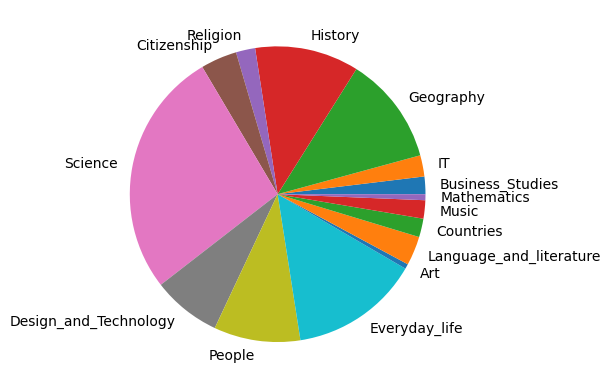

In [26]:
# Count how many times each category has occured as a target in the finished paths

# NOTE THAT SOME ARTICLES ARE REPRESENTED BY MULTIPLE CATEGORIES AND ARE COUNTED TWICE
all_target_broad_categories_u = [article_to_broad_category[target] for target in unfinished_paths_readable["target"] if target in article_to_broad_category]
all_target_broad_categories_u = [item for sublist in all_target_broad_categories_u for item in sublist]
count_cats_unfinished_target = Counter(all_target_broad_categories_u)
count_cats_unfinished_target

display(count_cats_unfinished_target)

ax = plt.pie(count_cats_unfinished_target.values(), labels = count_cats_unfinished_target.keys())
plt.show()

# There are certain categories that show up more or less here proportionally!

In [27]:
# Which countries are targets in finished paths

country_targets_f = [target for target in [path[-1] for path in finished_paths_readable["readable_path"]] if target in article_to_broad_category and "Countries" in article_to_broad_category[target]]
count_countries_finished_target = Counter(country_targets_f)
display(count_countries_finished_target)

Counter({'China': 114,
         'Vietnam': 93,
         'Japan': 83,
         'Russia': 80,
         'Canada': 75,
         'United_Arab_Emirates': 56,
         'Italy': 54,
         'Germany': 49,
         'Dubai': 48,
         'Kazakhstan': 46,
         'Afghanistan': 45,
         'Hungary': 45,
         'Brazil': 41,
         'Iraq': 41,
         'Australia': 39,
         'Republic_of_China': 39,
         'Tanzania': 38,
         'Sweden': 37,
         'Czech_Republic': 36,
         'Cuba': 36,
         'Mexico': 35,
         'South_Africa': 35,
         'Finland': 34,
         'Hong_Kong': 34,
         'Peru': 34,
         'Korea': 33,
         'Portugal': 32,
         'Zimbabwe': 32,
         'Dominican_Republic': 32,
         'Niger': 31,
         'Chile': 31,
         'Greenland': 31,
         'Venezuela': 31,
         'Jamaica': 31,
         'Denmark': 30,
         'Jordan': 30,
         'Austria': 30,
         'North_Korea': 30,
         'India': 29,
         'Greece': 28,
   

In [28]:
# Which countries are targets in unfinished paths

country_targets_u = [target for target in unfinished_paths_readable["target"] if target in article_to_broad_category and "Countries" in article_to_broad_category[target]]
count_countries_unfinished_target = Counter(country_targets_u)
display(count_countries_unfinished_target)

# There are certainly some trends here. Haiti, Samoa, and the Gaza Strip, for example, are over-represented in the unfinished paths
# when compared to the finished paths.


Counter({'Vietnam': 17,
         'Japan': 11,
         'Haiti': 10,
         'Samoa': 10,
         'Russia': 9,
         'Gaza_Strip': 9,
         'Kazakhstan': 9,
         'United_Arab_Emirates': 8,
         'Turks_and_Caicos_Islands': 8,
         'The_Bahamas': 8,
         'Réunion': 8,
         'Saint_Lucia': 7,
         'Cocos_(Keeling)_Islands': 7,
         'Fiji': 6,
         'Argentina': 6,
         'Peru': 6,
         'China': 6,
         'Jamaica': 6,
         'Papua_New_Guinea': 6,
         'Djibouti': 6,
         'Germany': 6,
         'Trinidad_and_Tobago': 6,
         'Christmas_Island': 6,
         'Brazil': 6,
         'Singapore': 5,
         'Jordan': 5,
         'Italy': 5,
         'British_Virgin_Islands': 5,
         'Kosovo': 5,
         'Indonesia': 5,
         'Thailand': 5,
         'Greece': 4,
         'Zimbabwe': 4,
         'Federated_States_of_Micronesia': 4,
         'Serbia': 4,
         'Croatia': 4,
         'Belgium': 4,
         'Nicaragua': 4,
     

In [29]:
# In fact we can see that there are some countries that occured as a target more in unfinished paths than in finished paths
count_countries_unfinished_target - count_countries_finished_target

Counter({'Samoa': 5,
         'Réunion': 4,
         'Turks_and_Caicos_Islands': 3,
         'British_Indian_Ocean_Territory': 3,
         'Saint_Kitts_and_Nevis': 3,
         'Saint_Vincent_and_the_Grenadines': 3,
         'Cocos_(Keeling)_Islands': 2,
         'Christmas_Island': 2})

In [30]:
total_country_counts = count_countries_unfinished_target + count_countries_finished_target
country_percent_in_unfinished = total_country_counts.copy()
country_percent_in_finished = total_country_counts.copy()

for item, count in country_percent_in_unfinished.items():
    country_percent_in_unfinished[item] = count_countries_unfinished_target[item] / total_country_counts[item]

for item, count in country_percent_in_finished.items():
    country_percent_in_finished[item] = count_countries_finished_target[item] / total_country_counts[item]

In [31]:
country_percent_in_unfinished

Counter({'British_Indian_Ocean_Territory': 1.0,
         'Saint_Kitts_and_Nevis': 1.0,
         'Saint_Vincent_and_the_Grenadines': 1.0,
         'Samoa': 0.6666666666666666,
         'Réunion': 0.6666666666666666,
         'Turks_and_Caicos_Islands': 0.6153846153846154,
         'Christmas_Island': 0.6,
         'Cocos_(Keeling)_Islands': 0.5833333333333334,
         'Antigua_and_Barbuda': 0.5,
         'French_Polynesia': 0.5,
         'Saint_Lucia': 0.4666666666666667,
         'Federated_States_of_Micronesia': 0.4444444444444444,
         'Anguilla': 0.4444444444444444,
         'Fiji': 0.42857142857142855,
         'Saint_Helena': 0.42857142857142855,
         'Haiti': 0.4166666666666667,
         'East_Timor': 0.4,
         'Trinidad_and_Tobago': 0.4,
         'The_Bahamas': 0.4,
         'Gaza_Strip': 0.391304347826087,
         'Singapore': 0.38461538461538464,
         'Nicaragua': 0.36363636363636365,
         'Papua_New_Guinea': 0.35294117647058826,
         'Oman': 0.333333

In [32]:
country_percent_in_finished

Counter({'Spain': 1.0,
         'Sweden': 1.0,
         'Somalia': 1.0,
         "Côte_d'Ivoire": 1.0,
         'Gabon': 1.0,
         'Lithuania': 1.0,
         'Netherlands': 1.0,
         'United_Kingdom': 1.0,
         'Austria': 1.0,
         'Cook_Islands': 1.0,
         'Estonia': 1.0,
         'Abkhazia': 1.0,
         'Moldova': 1.0,
         'The_Gambia': 1.0,
         'Sri_Lanka': 1.0,
         'Panama': 1.0,
         'Luxembourg': 1.0,
         'Central_African_Republic': 1.0,
         'Equatorial_Guinea': 1.0,
         'South_Ossetia': 1.0,
         'Honduras': 1.0,
         'Malawi': 1.0,
         'Vatican_City': 1.0,
         'Grenada': 1.0,
         'Montenegro': 1.0,
         'Bosnia_and_Herzegovina': 1.0,
         'French_Guiana': 1.0,
         'Guinea-Bissau': 1.0,
         'Australia': 0.975,
         'Canada': 0.974025974025974,
         'Greenland': 0.96875,
         'Paraguay': 0.9642857142857143,
         'Iran': 0.9615384615384616,
         'Dubai': 0.96,
     

### Analyze Networkx graph objects 
degreehistograms, etc. etc.

#### Next Idea

### Exploration Specific to Idea 1
Explore specific questions as noted in notion

In [33]:
# TODO: generate some summary stats on the wikipedia articles (length, number of hyperlinks etc. from the additional data given in teh task (not laoded yet)) to check some of our hypotheses

### Exploration Specific to Idea 2
Explore specific questions as noted in notion

### Exploration Specific to Idea 3
Explore specific questions as noted in notion

### Exploration Specific to Idea 4
Explore specific questions as noted in notion

### Exploration Specific to Idea 5
Explore specific questions as noted in notion